# Explore RNAseq of FAC Sorted UV cones from 7 dpf zebrafish: <br> ventro-temporal retina vs. rest of retina <br> ([Yoshimatsu _et al._, 2020](https://doi.org/10.1016/j.neuron.2020.04.021))

This notebook can be accessed here:  
[angueyraLab.github.io/drRNAseq/lab](angueyraLab.github.io/drRNAseq/lab)  

## Yoshimatsu dataset made available by authors and deposited here:  
https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/data/Yoshimatsu2020_UVcones_acuteZone.csv

From the authors
> "Whole 7 dpf Tg(opn1sw1:GFP) larval zebrafish retinas were dissected in carboxygenated aCSF while keeping track of each retina’s orientation. Each retina was then cut into two pieces: _strike zone_, and _non-strike-zone_. Typically tissues from ∼10 fish (20 eyes) were batched into one tube and dissociated. [...] Approximately 100 cells were sorted in one tube, [...] and subjected to next generation sequencing. In total, four repeats each were performed for SZ and non-SZ samples."

Some notes
> Provided data by the authors is organized according to ensemblID. Used BioMart to convert to NCBI gene symbol, but there is redundant mapping (e.g. _tbx2a_ has 2 ensemblID entries: ENSDARG00000109541 and ENSDARG00000018025), mainly empty mapping from alternative annotations. Perhaps best to add them together? Could also just remove all 0 entries?

## Instructions to explore dataset:  
https://github.com/angueyraLab/drRNAseq

----
----

### How to use the notebook
- To explore the datasets, you will need to run the code in the cells below.  
- To run a cell, you need to click unto it to select it and press "Ctrl"+"Enter" or the small *play* symbol in the navigation bar on top of this notebook.  
- Cells that are currently running display [\*] on the left.  
- Cells that have finished running will display a number instead (e.g.[8])
---
---
#### Saving plots:
- Right click on the image and click on "Create New View for Output"
- Right click on image in Output View panel and click on "Save As..."

#### First: load python environment

In [1]:
import pyolite
print("Successfully loaded pyolite version {0}".format(pyolite.__version__))

Successfully loaded pyolite version 0.1.0b4


#### Second: load all necessary extensions (this may take a few minutes...)

In [60]:
print("Loading extensions...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import zscore
import os
import pyodide
import piplite

# await piplite.install('ipywidgets')
URL = 'https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/widgetsnbextension-4.0.3-py3-none-any.whl'
await piplite.install(URL)
URL = 'https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/ipywidgets-8.0.2-py3-none-any.whl'
await piplite.install(URL)
import ipywidgets
pBGMenu = ipywidgets.Dropdown(options=['Light', 'Dark'],value='Light',disabled=False, layout=ipywidgets.Layout(width='20%', height='40px'))
pBGLabel = ipywidgets.widgets.Label('Select plotting style', layout=ipywidgets.Layout(width='20%', height='30px'))
pBG = ipywidgets.widgets.VBox([pBGLabel,pBGMenu])
heatmapNorm = ipywidgets.Checkbox(value=False, description='Heatmap normalization', disabled=False)

# Load plotting function
URL = 'https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/juanPlot-0a2-py2.py3-none-any.whl'
await piplite.install(URL)
from juanPlot import *
print("Successfully loaded extensions!")

# load datasets
print("Loading datasets...")
URL = 'https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/data/Yoshimatsu2020_UVcones_acuteZone.csv'
zfY = pd.read_csv(pyodide.open_url(URL))
print("\t Yoshimatsu et al. (2020)")


print("Successfully loaded dataset(s)!\n\n")

# Display selector for plotting background:
pBG

Loading extensions...
Successfully loaded extensions!
Loading datasets...
	 Yoshimatsu et al. (2020)
Successfully loaded dataset(s)!




#### Define some plotting bases and colors

In [4]:
# photoreceptor Colors
pC = {
    'r' : '#747474', # Rods
    'u' : '#B540B7', # UV cones
    'u2' : '#B789A7', # UV cones version 2
    's' : '#4669F2', # S cones
    'm' : '#04CD22', # M cones
    'l' : '#CC2C2A', # L cones
    'm4': '#cdcd04', # opn1mws4-expressing M cones
    'onBC': '#ccf2ff', # on bipolar cells
    'offBC': '#663d00', # off bipolar cells
    'plt' : '',
    'zfO': '',
}

# default parameters for plotting
if pBGMenu.value=='Dark':
    # dark background
    plt.style.use('dark_background')
    params = {"ytick.color" : "w", "xtick.color" : "w",
              "axes.labelcolor" : "w", "axes.edgecolor" : "w",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3, "ytick.major.width" : 3,
             "xtick.major.size" : 8, "ytick.major.size" : 8,
             "text.color" : "w"}
    plt.rcParams.update(params)
    baseColor = '#ffffff' #white
else:
    # white background
    plt.style.use('default')
    params = {"ytick.color" : "k", "xtick.color" : "k",
              "axes.labelcolor" : "k", "axes.edgecolor" : "k",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3, "ytick.major.width" : 3,
             "xtick.major.size" : 8, "ytick.major.size" : 8,
             "text.color" : "k"}
    plt.rcParams.update(params)
    baseColor = '#000000' #black
    


print("Plotting style is: {0}".format(pBGMenu.value))

Plotting style is: Light


### temp plotting functions

In [79]:
def plotBars_Yoshimatsu2020(barData, geneSymbol, ax=None, pC=None):
    """Creates a bar plot for a single gene for data from Yoshimatsu et al. (2020) (https://doi.org/10.1016/j.neuron.2020.04.021)
    Arguments:
        barData         : a 1D numpy array
        geneSymbol      : gene Symbol for plot title
        ax              : pyplot axis handle
        pC              : photoreceptor colors for plotting
    """
    n = np.arange(1,5) # non-strike zone UV cones
    n = np.append(n, 5 + np.arange(1,5)) # strike zone UV cones
    h_start = 1
    h_end = 9
    h = barData.iloc[0,h_start:h_end].to_numpy()
    # color array for bar plot
    if not pC:
        pC = {'u' : '#B540B7','u2' : '#B789A7'}
    barColors = [
        pC['u2'],pC['u2'],pC['u2'],pC['u2'],
        pC['u'],pC['u'],pC['u'],pC['u']
    ]
    if not ax:
        ax = plt.gca()
    pH = ax.bar(n, h, width=0.8, bottom=None, align='center', data=None, color=barColors)
    formatBarPlot_Yoshimatsu2020(geneSymbol, ax=ax)
    return pH

def formatBarPlot_Yoshimatsu2020(geneSymbol, ax=None):
    if not ax:
        ax = plt.gca()
    [fontTicks, fontLabels, fontTitle] = defaultFonts(ax = ax);
    ax.set_xticks([2.5,7.5])
    ax.set_xticklabels(['UV$_{non-sz}$','UV$_{sz}$']);
    ax.set_ylabel('cpm', fontproperties=fontLabels)
    ax.set_title(geneSymbol, fontproperties=fontTitle)
    
    
def heatmap_Yoshimatsu2020(heatmapData, ax=None, pC=None, norm=False):
    """Main call for heatmap for data from Sun, Galicia and Stenkamp (2018)
    Arguments:
        heatmapData : pandas dataframe containing expression data to be plotted
        pC : dict with custom photoreceptor colors
        norm : boolean that determines if plotting is raw data or row-normalized
    Returns:
        hmH : heatmap handle
        cbH : colorbar handle
    """
    genenames = heatmapData['symbol'].values
    data = heatmapData.iloc[0:,1:9].values #in cpm
    cbarlabel = "cpm"
    if norm:
        data = heatmapData.iloc[0:,1:9].apply(lambda x: x/x.max(), axis=1).values #normalized by max
        cbarlabel = "norm. cpm"
    groupsN = np.array([4,4])
    if not pC:
        pC = {'u' : '#B540B7','u2' : '#B789A7'}
    groupsColors = np.array([pC['u2'],pC['u']])
    groupsLabels = np.array(['UV$_{non-sz}$','UV$_{sz}$'])
    if not ax:
        ax = plt.gca()
    hmH, cbH = heatmap_general(data, genenames, [], groupsN, groupsColors, groupsLabels, ax=ax, cbarlabel=cbarlabel)
    return hmH, cbH

***
# Index <a id='Index'></a>
- [Bar plot for single gene: Nerli et al. (2022)](#barPlot42hpf)
- [Heatmap for gene family: Nerli et al. (2022)](#heatMap42hpf)

***
## Bar plot for single gene: provide gene symbol (e.g. '_gnat2_')<a id='barPlot42hpf'></a>
***
[Back to Index](#Index)

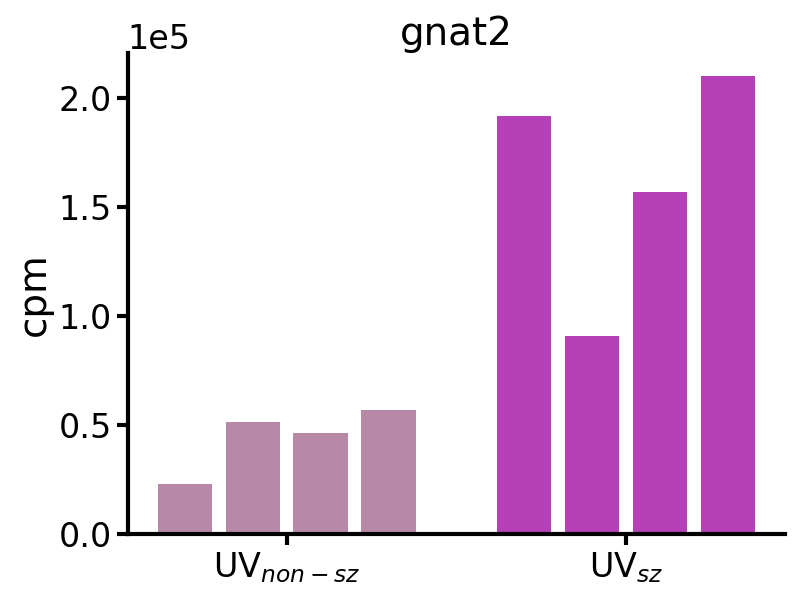

In [99]:
geneSymbol = 'gnat2' # replace geneSymbol here and rerun cell to replot

barData = zfY[zfY['symbol']==geneSymbol] #get data (should add a check here with isin)
fH, axH = plt.subplots(figsize=(8,6))
pH = plotBars_Yoshimatsu2020(barData, geneSymbol, ax=axH, pC=pC)
plt.subplots_adjust(left=0.15, right=.95, top=0.90, bottom=0.1)
plt.tight_layout()
plt.show()

***
## HeatMap for gene family: provide gene symbol prefix (e.g. '_opn1_')<a id='heatMap'></a>
> retrieves all genes whose symbol starts with defined geneSymbol  
***

[Back to Index](#Index)

In [41]:
# display option for heatmap normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

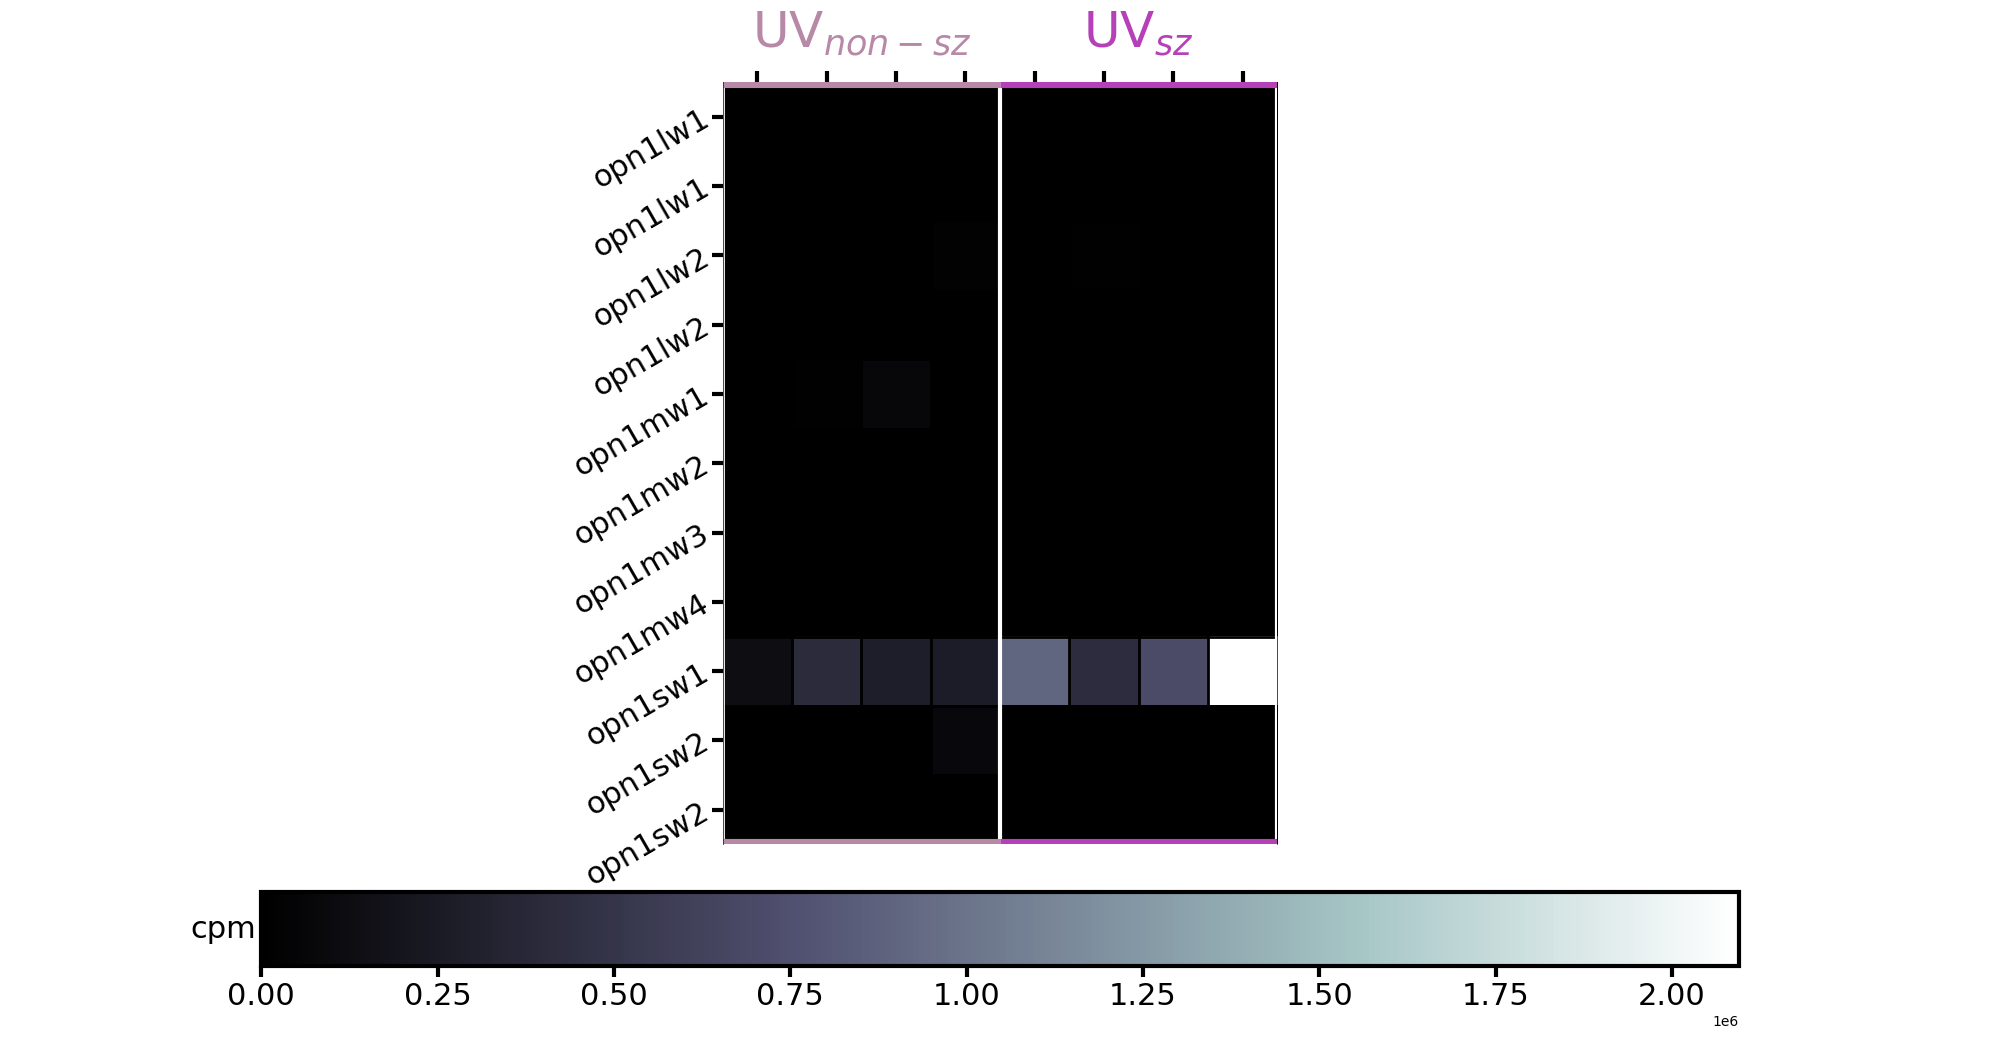

In [95]:
geneSymbol='opn1' # replace geneSymbol here and rerun cell to replot

heatmapDataY = zfY[zfY['symbol'].str.startswith(geneSymbol)==True]
heatmapDataY = heatmapDataY.sort_values(by=["symbol"])
fH, axH = plt.subplots(figsize=(20,(0.5*heatmapDataY.shape[0])+5))
hmH, cbH = heatmap_Yoshimatsu2020(heatmapDataY, pC = pC, norm=heatmapNorm.value)
plt.tight_layout()
plt.show()

***
## HeatMap for gene list: provide gene symbols separated by "|" (e.g. '_tbx2a_|_tbx2b_|_foxq2_')<a id='heatMapList'></a>
> retrieves all genes in list and creates heatmap  
***

[Back to Index](#Index)

In [89]:
# display option for heatmap normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

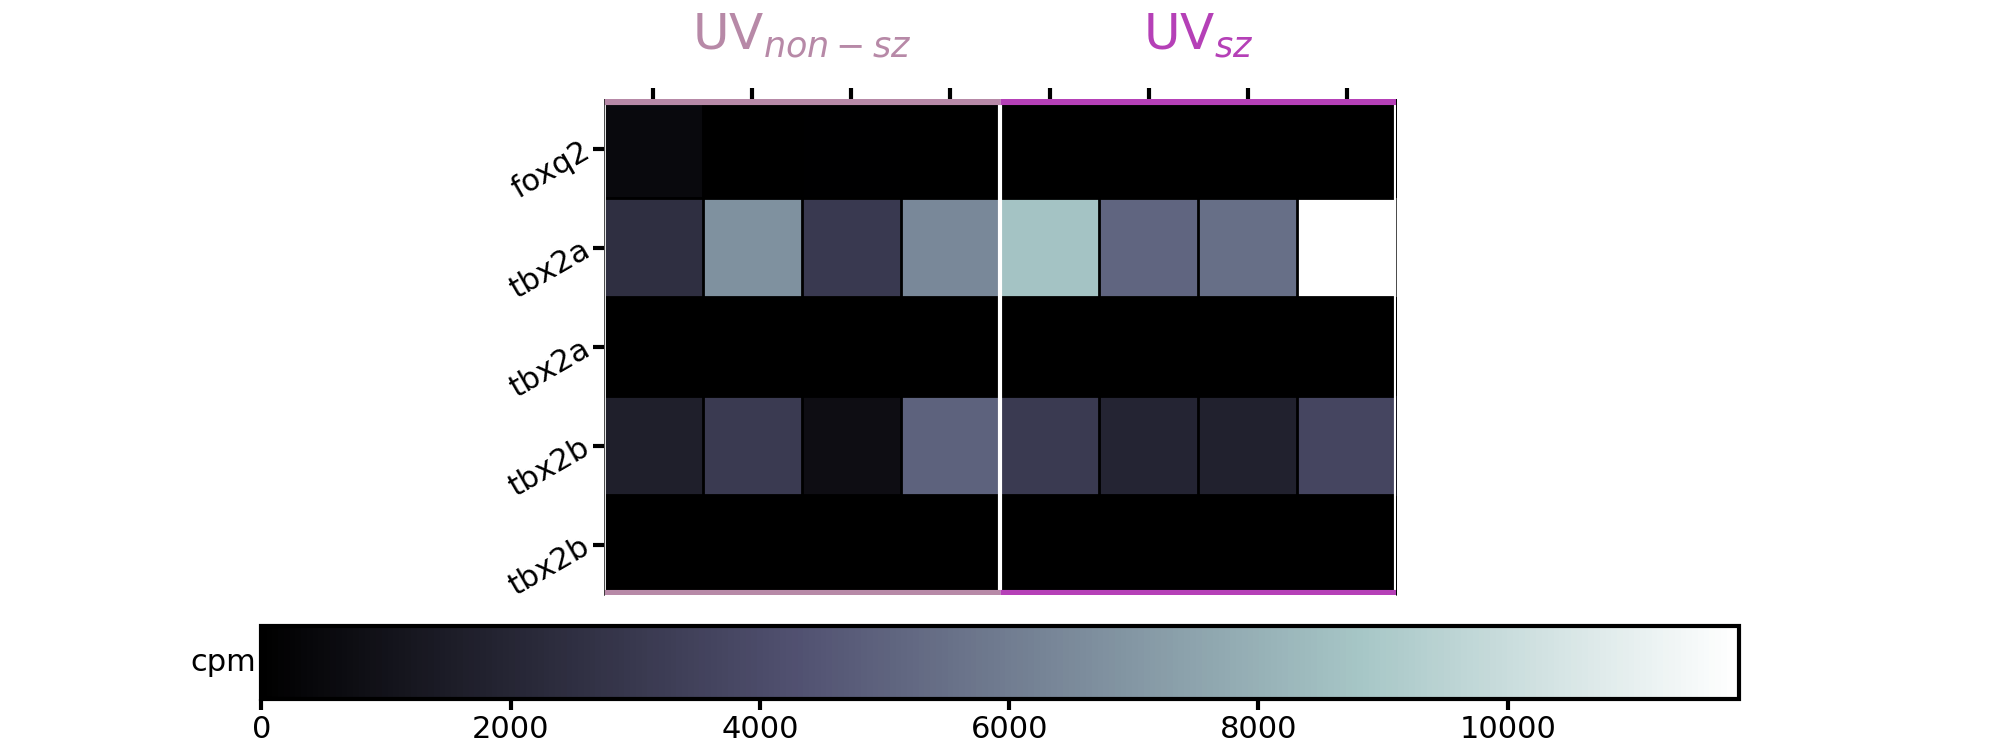

In [94]:
geneSymbol='tbx2a|tbx2b|foxq2' # replace geneSymbol here and rerun cell to replot

heatmapDataY = zfY[zfY['symbol'].str.contains(geneSymbol)==True]
heatmapDataY = heatmapDataY.sort_values(by=["symbol"])
fH, axH = plt.subplots(figsize=(20,(0.5*heatmapDataY.shape[0])+5))
hmH, cbH = heatmap_Yoshimatsu2020(heatmapDataY, pC = pC, norm=heatmapNorm.value)
plt.tight_layout()
plt.show()